In [2]:
import pandas as pd
import tqdm
import numpy as np
import glob, pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Load train set on cesium format
cs_ = glob.glob('../data/training_cesium_curves/*.pkl')
oids_ = glob.glob('../data/training_cesium_curves/*.npy')

ts_a = []
ms_a = []
es_a = []
ds_a = []
oids_a = []

for c_, o_ in zip(cs_, oids_):
    with open(c_, 'rb') as fp:
        full_c=pickle.load(fp)
    oids_a.append(np.load(o_))
    ts_a.extend(full_c[0])
    ms_a.extend(full_c[1])
    es_a.extend(full_c[2])
    ds_a.extend(full_c[3])
oids_a = np.hstack(oids_a)

# Load metadata and target/pred info
meta = pd.read_hdf('../data/train_dummy.h5')
meta['target'] = np.load('../data/target_dummy.npy')

In [18]:
meta.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,...,detected_mean_5,linreg_b1_back_mean,linreg_b1_front_mean,abs_magnitude_max_0,abs_magnitude_max_1,abs_magnitude_max_2,abs_magnitude_max_3,abs_magnitude_max_4,abs_magnitude_max_5,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,NaN,0.017,...,0.912281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.6267,0.2552,45.4063,0.007,...,0.000000,-0.018864,0.021511,-48.310455,NaN,-47.962273,-48.041904,NaN,-48.329815,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2262,0.0157,40.2561,0.021,...,0.078431,0.009107,-0.011246,NaN,NaN,-43.561375,-44.071045,-44.292290,-44.443485,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.2813,1.1523,40.7951,0.007,...,0.127273,NaN,-0.019768,-43.934128,-46.504734,-46.655075,-46.565182,-46.454979,-46.172092,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.2415,0.0176,40.4166,0.024,...,0.070175,NaN,-0.013384,NaN,-44.342087,-45.486725,-45.780510,-45.809486,-45.511734,90


<Figure size 432x288 with 0 Axes>

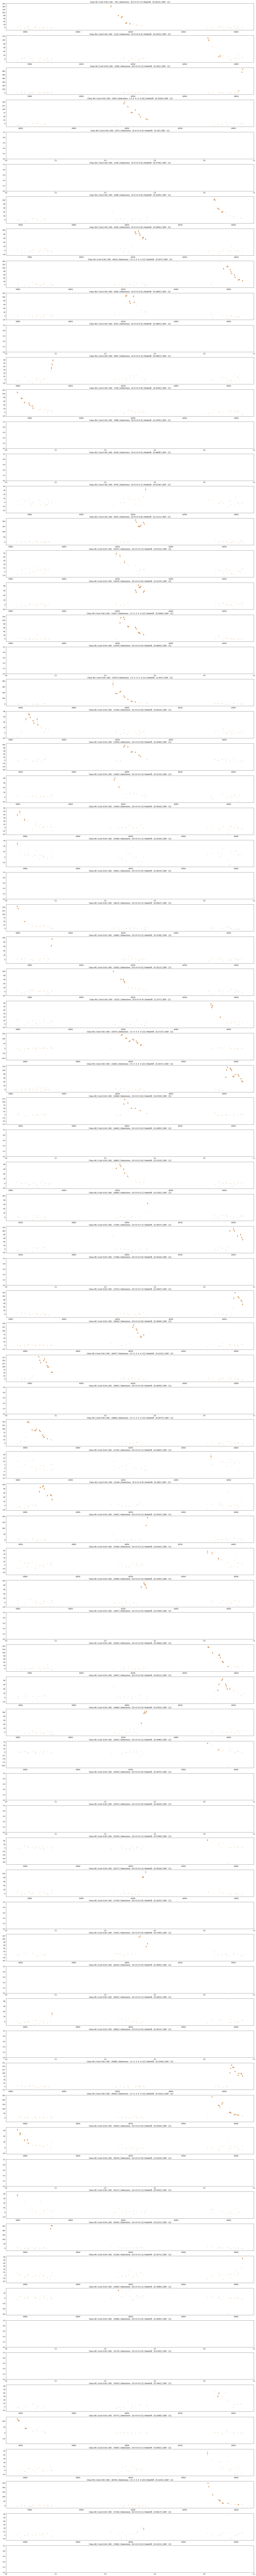

In [91]:
'''
CURVE FIT PROTOTYPE
'''
from scipy.optimize import minimize
def model(t, params):
    a0, t0, trise, tfall = params
    return a0 * np.e ** (-(t-t0) / tfall) / (1 + np.e ** (-(t-t0) / trise))

def msqe(x0, *args):
    tds, mds = args
    return np.sum((model(tds, x0) - mds)**2)

# Select sn class
target=90

distmods = meta['distmod'].values

# Select number of curves to plot
N_CURVES = 80

# Plt confs
plt.close('all')
plt.cla()
plt.clf()

f, axs = plt.subplots(N_CURVES, 1, sharex=False, sharey=False, figsize=(30,N_CURVES*4))
colors = ['darkorchid', 'royalblue', 'forestgreen', 'orange', 'indianred', 'peru']

sn_oids = meta.loc[(meta['target']==target),'object_id'].values

mask = np.arange(0, len(ts_a))[np.isin(oids_a, sn_oids)]
ts = [ts_a[i] for i in mask]
ms = [ms_a[i] for i in mask]
es = [es_a[i] for i in mask]
ds = [ds_a[i] for i in mask]
oids = oids_a[mask]

# Fit presets
x = np.linspace(59400, 62000, 1000)

msqes = []
for j, (tt, mm, ee, dd, oidd, distmod) in enumerate(zip(ts[:N_CURVES], ms[:N_CURVES], es[:N_CURVES], ds[:N_CURVES], oids[:N_CURVES], distmods[:N_CURVES])):

    # Determine scaling factor
    m_max = []
    t_max = []
    for band_num, (t,m,e,d) in enumerate(zip(tt,mm,ee,dd)):

        if np.sum(d) > 0:
            m_max.append(np.max(m[d.astype(bool)]))
            t_max.append(t[d.astype(bool)][np.argmax(m[d.astype(bool)])])

    m_max = np.max(m_max)
    t_max = np.min(t_max)

    det_count = np.zeros(6)
    for band_num, (t,m,e,d) in enumerate(zip(tt,mm,ee,dd)):
        
        if band_num != 5:
            continue
        det_count[band_num] = np.sum(d)
        if det_count[band_num] > 0:
            
            # Detection mask
            s=40
            size_m = np.ones(len(d))*s
            size_m[np.logical_not(d.astype(bool))] *= .1
            
            axs[j].scatter(t, m, s=size_m, c=colors[band_num], alpha=0.75, marker=None, cmap=None, norm=None, vmin=None, vmax=None)
            axs[j].errorbar(t[d.astype(bool)], m[d.astype(bool)], yerr=e[d.astype(bool)], fmt='.', c=colors[band_num], alpha=0.6)
    
    rs = meta.loc[meta['object_id']==oidd,'hostgal_photoz'].values   
    ddf = meta.loc[meta['object_id']==oidd,'ddf'].values   
    axs[j].set_title(f'Class {target:d} | Cost {msqerror:.2f} | OID : {oidd:d} | Detections : {det_count.astype(int)} | Redshift : {rs} | DDF : {ddf}')
    #axs[j].set_ylim(-0.2,1.2)

In [5]:
# Bounds auxiliary calculator, and other stats
# Load test set on cesium format
cs_ = glob.glob('../data/test_cesium_curves/*.pkl')
oids_ = glob.glob('../data/test_cesium_curves/*.npy')

ts_all = []
ms_all = []
ds_all = []

for c_, o_ in tqdm.tqdm(zip(cs_, oids_), total=len(cs_)):
    with open(c_, 'rb') as fp:
        full_c=pickle.load(fp)
    ts_all.extend(full_c[0])
    ms_all.extend(full_c[1])
    ds_all.extend(full_c[3])

100%|██████████| 64/64 [02:55<00:00,  2.74s/it]


In [12]:
maxfs, minfs = [], []
intervals = []
for ms, ts in tqdm.tqdm(zip(ms_all, ts_all), total=len(ms_all)):
    for i,(m,t) in enumerate(zip(ms, ts)):
        maxfs.append(np.max(m))
        minfs.append(np.min(m))
        intervals.append(t[1:]-t[:-1])
all_intervals = np.hstack(intervals)


  3%|▎         | 112424/3492890 [00:05<02:57, 19057.54it/s]
160649it [00:30, 5353.31it/s] 0 [00:06<02:57, 19039.81it/s]
 12%|█▏        | 433082/3492890 [00:26<03:08, 16210.44it/s]


 24%|██▎       | 828416/3492890 [00:53<02:52, 15432.79it/s]


 35%|███▍      | 1211880/3492890 [01:20<02:30, 15116.64it/s]


 45%|████▌     | 1582091/3492890 [01:46<02:08, 14845.85it/s]


 56%|█████▌    | 1951928/3492890 [02:12<01:44, 14680.05it/s]


 66%|██████▋   | 2317586/3492890 [02:39<01:20, 14528.74it/s]


 76%|███████▌  | 2661651/3492890 [03:06<00:58, 14265.71it/s]


 86%|████████▌ | 2990217/3492890 [03:33<00:35, 14006.70it/s]


 95%|█████████▍| 3318178/3492890 [04:00<00:12, 13782.16it/s]


100%|██████████| 3492890/3492890 [04:14<00:00, 13742.39it/s]

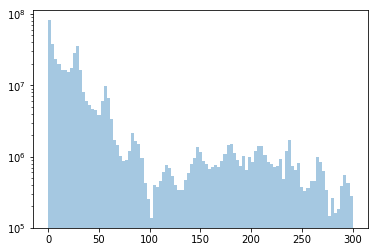

In [24]:
sns.distplot(all_intervals, kde=False, bins=np.linspace(0,300,100), hist_kws={'log':True})

In [26]:
# REPEAT BUT FOR TRAINING SET
cs_t = glob.glob('../data/training_cesium_curves/*.pkl')
oids_t = glob.glob('../data/training_cesium_curves/*.npy')

ts_all_t = []
ms_all_t = []
ds_all_t = []

for c_, o_ in tqdm.tqdm(zip(cs_t, oids_t), total=len(cs_t)):
    with open(c_, 'rb') as fp:
        full_c=pickle.load(fp)
    ts_all_t.extend(full_c[0])
    ms_all_t.extend(full_c[1])
    ds_all_t.extend(full_c[3])
    
tmaxfs, tminfs = [], []
tintervals = []
for ms, ts in tqdm.tqdm(zip(ms_all_t, ts_all_t), total=len(ms_all_t)):
    for i,(m,t) in enumerate(zip(ms, ts)):
        tmaxfs.append(np.max(m))
        tminfs.append(np.min(m))
        tintervals.append(t[1:]-t[:-1])
tall_intervals = np.hstack(tintervals)


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]

100%|██████████| 7848/7848 [00:00<00:00, 16996.58it/s]

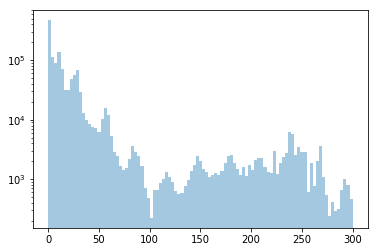

In [28]:
sns.distplot(tall_intervals, kde=False, bins=np.linspace(0,300,100), hist_kws={'log':True})

In [9]:
# Check sn fit params
sn_fits = np.load('../data/train_sn_fits.npy')

In [10]:
sn_fits = np.concatenate([sn_fits, np.tile(meta['target'].values, (6,1)).T[:,:,None]], axis=2)

In [11]:
df_slices = []
for b in [2,3,4]:
    df_slices.append(pd.DataFrame(sn_fits[:,b], columns=['a0','t0','trise','tfall','msqe','tgt']))

In [13]:
meta['target'].value_counts()

90    2313
42    1193
65     981
16     924
15     495
62     484
88     370
92     239
67     208
52     183
95     175
6      151
64     102
53      30
Name: target, dtype: int64

In [12]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
for s in df_slices:
    print(s.groupby('tgt')['msqe'].mean())

tgt
6.0        nan
15.0     189.9
16.0    2977.3
42.0    2791.8
52.0       nan
53.0       nan
62.0   27863.1
64.0       nan
65.0      76.9
67.0      10.9
88.0    1036.3
90.0    3725.6
92.0    1204.3
95.0       nan
Name: msqe, dtype: float64
tgt
6.0        nan
15.0     449.9
16.0    7482.9
42.0    1641.5
52.0       nan
53.0       nan
62.0   60669.4
64.0       nan
65.0     181.5
67.0     652.9
88.0    2096.7
90.0   11431.8
92.0    1917.7
95.0       6.9
Name: msqe, dtype: float64
tgt
6.0        nan
15.0     121.4
16.0    6834.7
42.0    6584.2
52.0       nan
53.0       nan
62.0    1100.9
64.0       nan
65.0      54.5
67.0     235.9
88.0    5477.0
90.0   14178.6
92.0    2901.6
95.0       0.1
Name: msqe, dtype: float64


In [74]:
def model(t, params):
    a0, t0, trise, tfall = params

    rise_exponent = -(t - t0) / trise
    fall_exponent = -(t - t0) / tfall

    res = a0 * np.e ** fall_exponent / (1 + np.e ** rise_exponent)

    return res

# Fast prototyping of sn train feats
oids = meta['object_id'].values
distmods = meta['distmod'].values
sn_feats = np.zeros((oids.size, 3*2)) # 2 feats per band : peak bright. and deltam15
sn_feats.fill(np.nan)
for i,oid in enumerate(oids):
    for j,band_num in enumerate([2,3,4]):
        
        if distmod==np.nan or sn_fits[i,band_num,-2] > 1500: # Intragal
            sn_feats[i, j*2:j*2+2] = np.array([np.nan, np.nan])
            continue
            
        # Get model params
        a0, t0, trise, tfall = sn_fits[i,band_num,0], sn_fits[i,band_num,1], sn_fits[i,band_num,2], sn_fits[i,band_num,3]
        
        # Calc t of peak brightness
        num = tfall * np.e ** (t0/trise) - trise * np.e ** (t0/trise)
        t_max = trise * np.log(num / trise)
        
        # Calc flux of peak brightness and +15day peak brightness
        params = (a0, t0, trise, tfall)
        fluxes = model(np.array([t_max, t_max+15]), params)
        
        # Convert to magnitudes

7843    130739978
7844    130755807
7845    130762946
7846    130772921
7847    130779836
Name: object_id, dtype: uint64